# SAGA GIS Tutorial - Terrain Analysis

## Overview

SAGA (System for Automated Geoscientific Analyses) is a powerful GIS platform with approximately 730 algorithms covering terrain analysis, hydrology, climate data processing, and more.

## What You'll Learn

This tutorial covers SAGA's terrain analysis capabilities including Slope and Aspect for basic terrain derivatives, Plan and Profile Curvature for landform characterization, Convergence Index to identify valleys and ridges, Topographic Wetness Index (TWI) to model moisture accumulation, and Terrain Ruggedness Index (TRI) to quantify surface roughness.

## Prerequisites

This notebook requires the `watershed_dem.tif` file created by running Notebook 03 (Watershed Delineation). The configuration file `watershed_analysis.json` from Notebook 01 must also be present.

## Setup: Load Configuration and Imports

In [21]:
import json
import os
import subprocess
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')

# Load configuration
with open('watershed_analysis.json', 'r') as f:
    config = json.load(f)

# Create output directories
os.makedirs(config["temp_dir"], exist_ok=True)
os.makedirs(config["output_dir"], exist_ok=True)

# Use watershed DEM from Notebook 03
watershed_dem = os.path.join(config['output_dir'], 'watershed_dem.tif')
if not os.path.exists(watershed_dem):
    raise FileNotFoundError("watershed_dem.tif not found - run 03_Watershed_Delineation first!")

print("Setup complete")
print(f"Watershed DEM: {watershed_dem}")

Setup complete
Watershed DEM: results/watershed_dem.tif


## Helper Functions for SAGA

This cell defines helper functions for running SAGA tools and visualizing results. The `run_saga_tool()` function executes SAGA commands via the command line. The `visualize_raster()` function creates matplotlib visualizations with appropriate axis labels based on the coordinate reference system.

In [28]:
def run_saga_tool(library, tool_id, parameters, verbose=False):
    """
    Execute a SAGA GIS tool
    """
    env = {
        'LD_LIBRARY_PATH': '/opt/saga/lib:/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu:/opt/conda/envs/pygile/lib',
        'SAGA_MLB': config['saga_lib']
    }
    
    cmd = [config['saga_cmd'], library, str(tool_id)] + parameters
    
    if verbose:
        print(f"Running: {' '.join(cmd)}")
    
    result = subprocess.run(cmd, env=env, capture_output=True, text=True)
    
    if result.returncode != 0:
        print(f"Error running SAGA tool:")
        print(result.stderr)
        raise Exception(f"SAGA tool failed")
    
    return result


def visualize_raster(file_path, title, cmap='viridis', figsize=(10, 8), percentile=(2, 98)):
    """
    Visualize a raster file with matplotlib
    """
    with rasterio.open(file_path) as src:
        data = src.read(1, masked=True)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        crs = src.crs
    
    # Determine appropriate vmin/vmax
    valid_data = data[~data.mask] if hasattr(data, 'mask') else data[~np.isnan(data)]
    
    if 'Slope' in title:
        vmin, vmax = 0, 60
    elif len(valid_data) > 0:
        vmin, vmax = np.percentile(valid_data, percentile)
    else:
        vmin, vmax = np.nanmin(data), np.nanmax(data)
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(data, cmap=cmap, extent=extent, aspect='equal', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=13, fontweight='bold', pad=12)
    
    # Set axis labels based on CRS
    if crs and crs.is_projected:
        ax.set_xlabel('Easting (m)', fontsize=10)
        ax.set_ylabel('Northing (m)', fontsize=10)
    else:
        ax.set_xlabel('Longitude (degrees)', fontsize=10)
        ax.set_ylabel('Latitude (degrees)', fontsize=10)
    
    ax.ticklabel_format(style='plain', useOffset=False)
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right', fontsize=9)
    plt.setp(ax.get_yticklabels(), fontsize=9)
    
    cbar = plt.colorbar(im, ax=ax, shrink=0.5, pad=0.03)
    cbar.ax.tick_params(labelsize=9)
    
    plt.tight_layout()
    plt.show()
    plt.close()


def compute_statistics(file_path):
    """
    Compute basic statistics for a raster file
    """
    with rasterio.open(file_path) as src:
        data = src.read(1, masked=True)
    
    valid_data = data[~data.mask] if hasattr(data, 'mask') else data[~np.isnan(data)]
    
    return {
        'min': np.min(valid_data) if len(valid_data) > 0 else np.nan,
        'max': np.max(valid_data) if len(valid_data) > 0 else np.nan,
        'mean': np.mean(valid_data) if len(valid_data) > 0 else np.nan,
        'std': np.std(valid_data) if len(valid_data) > 0 else np.nan,
        'median': np.median(valid_data) if len(valid_data) > 0 else np.nan
    }


print("Helper functions loaded")

Helper functions loaded


## Preprocessing: Reproject DEM to UTM

For accurate terrain analysis, the DEM must be in a projected coordinate system with meters as the unit. This cell reprojects the watershed DEM from geographic coordinates (degrees) to UTM Zone 45N (EPSG:32645) which uses meters. This ensures slope, curvature, and other derivatives are calculated correctly.

In [29]:
print("Preprocessing: Reprojecting DEM to UTM...\n")

# Step 1: Reproject DEM to UTM meters (EPSG:32645)
watershed_dem_utm = os.path.join(config['output_dir'], 'watershed_dem_utm.tif')
subprocess.run([
    "gdalwarp",
    "-t_srs", "EPSG:32645",
    "-r", "bilinear",
    "-overwrite",
    "-of", "GTiff",
    watershed_dem,
    watershed_dem_utm
], check=True)
print(f"Reprojected DEM saved to: {watershed_dem_utm}")

# Step 2: Create a cleaned DEM for SAGA (handle NoData values)
cleaned_dem = os.path.join(config['output_dir'], 'watershed_dem_clean_saga.tif')
with rasterio.open(watershed_dem_utm) as src:
    dem = src.read(1).astype(float)
    profile = src.profile
    
    # Mask NoData values
    dem[dem == -9999] = np.nan
    if src.nodata is not None:
        dem[dem == src.nodata] = np.nan
    
    profile.update(dtype=rasterio.float32, nodata=np.nan)
    
    with rasterio.open(cleaned_dem, 'w', **profile) as dst:
        dst.write(dem.astype(rasterio.float32), 1)

print(f"Cleaned DEM saved to: {cleaned_dem}")

# Print info
with rasterio.open(cleaned_dem) as src:
    print(f"\nDEM Info:")
    print(f"  CRS: {src.crs}")
    print(f"  Resolution: {src.res[0]:.2f} m")
    print(f"  Bounds: {src.bounds}")

Preprocessing: Reprojecting DEM to UTM...

Creating output file that is 1130P x 800L.
Using internal nodata values (e.g. -9999) for image results/watershed_dem.tif.
Copying nodata values from source results/watershed_dem.tif to destination results/watershed_dem_utm.tif.
Processing results/watershed_dem.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Reprojected DEM saved to: results/watershed_dem_utm.tif
Cleaned DEM saved to: results/watershed_dem_clean_saga.tif

DEM Info:
  CRS: EPSG:32645
  Resolution: 28.12 m
  Bounds: BoundingBox(left=-140482.12713386572, bottom=3267729.3971067015, right=-108708.48229046552, top=3290224.012925038)


## 1. Slope and Aspect Analysis

**Slope** measures the rate of change in elevation, indicating how steep the terrain is. It is fundamental for erosion risk assessment, construction planning, habitat modeling, and landslide susceptibility analysis.

**Aspect** indicates the compass direction that a slope faces. North-facing versus south-facing slopes receive different solar radiation, affecting vegetation patterns, snow accumulation, and erosion rates.

**SAGA Tool**: `ta_morphometry` module 0

In [30]:
print("Calculating Slope and Aspect...\n")

slope_file = os.path.join(config['output_dir'], 'saga_slope.tif')
aspect_file = os.path.join(config['output_dir'], 'saga_aspect.tif')

run_saga_tool(
    library='ta_morphometry',
    tool_id=0,
    parameters=[
        f'-ELEVATION={cleaned_dem}',
        f'-SLOPE={slope_file}',
        f'-ASPECT={aspect_file}',
        f'-UNIT_SLOPE={config["slope_unit_saga"]}',
        '-UNIT_ASPECT=0'
    ]
)

print(f"Slope saved to: {slope_file}")
print(f"Aspect saved to: {aspect_file}")

Calculating Slope and Aspect...

Slope saved to: results/saga_slope.tif
Aspect saved to: results/saga_aspect.tif


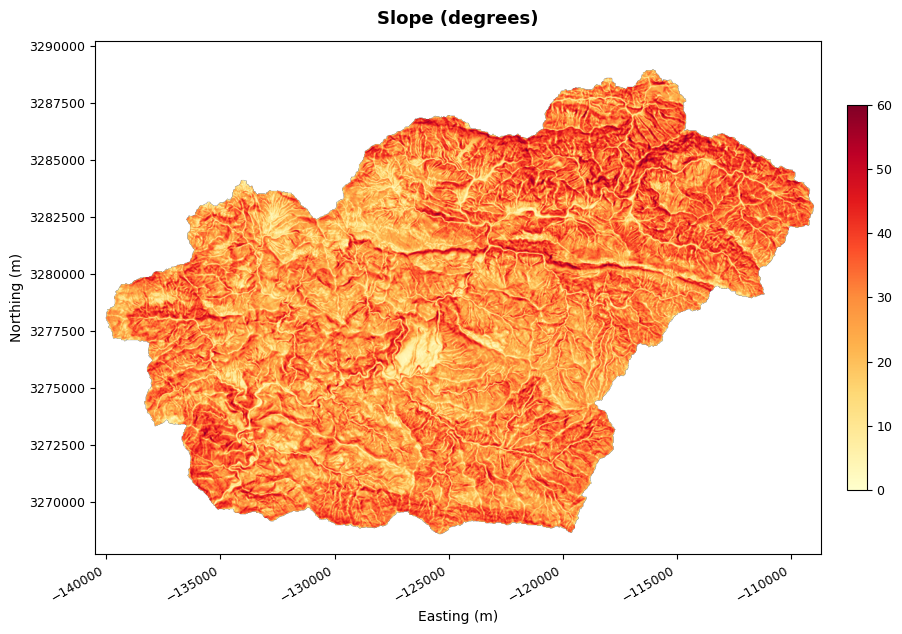

In [31]:
visualize_raster(
    slope_file, 
    title='Slope (degrees)', 
    cmap='YlOrRd',
    percentile=(0, 95)
)

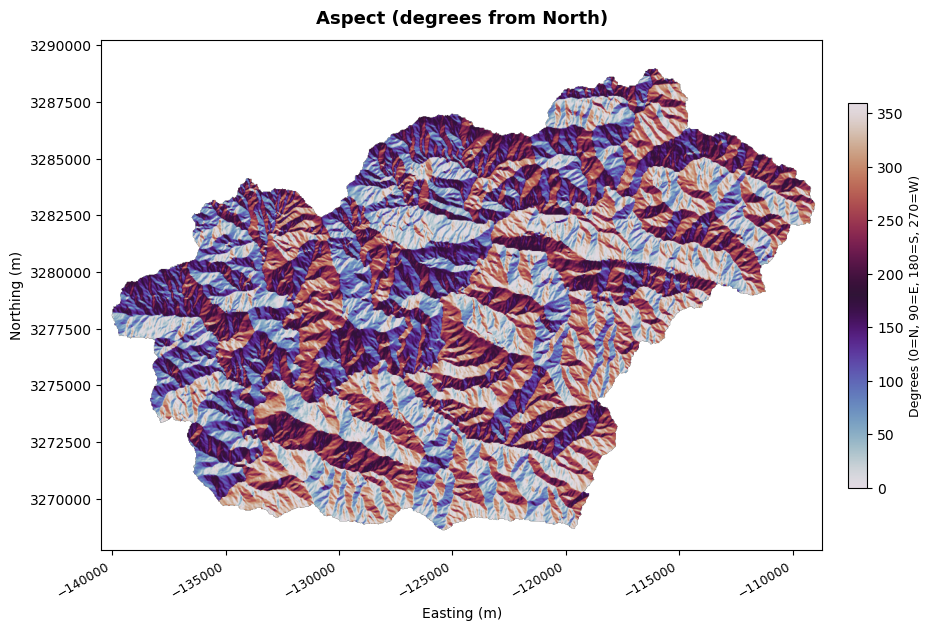

In [32]:
# Visualize Aspect with proper radian to degree conversion
with rasterio.open(aspect_file) as src:
    aspect_data = src.read(1, masked=True).copy()
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    crs = src.crs

# Convert radians to degrees
aspect_degrees = np.degrees(aspect_data)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(aspect_degrees, cmap='twilight', extent=extent, aspect='equal', vmin=0, vmax=360)
ax.set_title('Aspect (degrees from North)', fontsize=13, fontweight='bold', pad=12)

if crs and crs.is_projected:
    ax.set_xlabel('Easting (m)', fontsize=10)
    ax.set_ylabel('Northing (m)', fontsize=10)
else:
    ax.set_xlabel('Longitude (degrees)', fontsize=10)
    ax.set_ylabel('Latitude (degrees)', fontsize=10)

ax.ticklabel_format(style='plain', useOffset=False)
plt.setp(ax.get_xticklabels(), rotation=30, ha='right', fontsize=9)

cbar = plt.colorbar(im, ax=ax, shrink=0.5, pad=0.03)
cbar.set_label('Degrees (0=N, 90=E, 180=S, 270=W)', fontsize=9)

plt.tight_layout()
plt.show()
plt.close()

## 2. Curvature Analysis

Curvature measures how the terrain surface bends in different directions.

**Plan Curvature** (horizontal) measures curvature perpendicular to the slope direction. Positive values indicate convex surfaces (ridges) where flow diverges. Negative values indicate concave surfaces (valleys) where flow converges.

**Profile Curvature** (vertical) measures curvature parallel to the slope direction. Positive values indicate convex crests where slope decreases downslope. Negative values indicate concave depressions where slope increases downslope.

**SAGA Tool**: `ta_morphometry` module 0

In [33]:
print("Calculating Plan and Profile Curvature...\n")

plan_curv_file = os.path.join(config['output_dir'], 'saga_plan_curvature.tif')
prof_curv_file = os.path.join(config['output_dir'], 'saga_profile_curvature.tif')

# Use the cleaned UTM-projected DEM
run_saga_tool(
    library='ta_morphometry',
    tool_id=0,
    parameters=[
        f'-ELEVATION={cleaned_dem}',
        f'-C_PLAN={plan_curv_file}',
        f'-C_PROF={prof_curv_file}'
    ]
)

print(f"Plan curvature saved to: {plan_curv_file}")
print(f"Profile curvature saved to: {prof_curv_file}")

Calculating Plan and Profile Curvature...

Plan curvature saved to: results/saga_plan_curvature.tif
Profile curvature saved to: results/saga_profile_curvature.tif


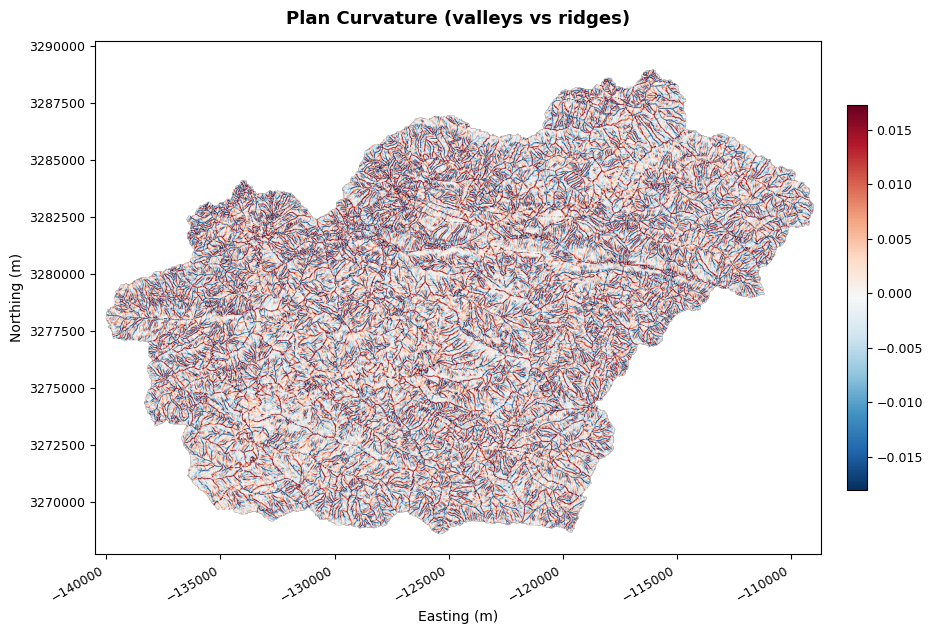

In [34]:
visualize_raster(
    plan_curv_file,
    title='Plan Curvature (valleys vs ridges)',
    cmap='RdBu_r',
    percentile=(5, 95)
)

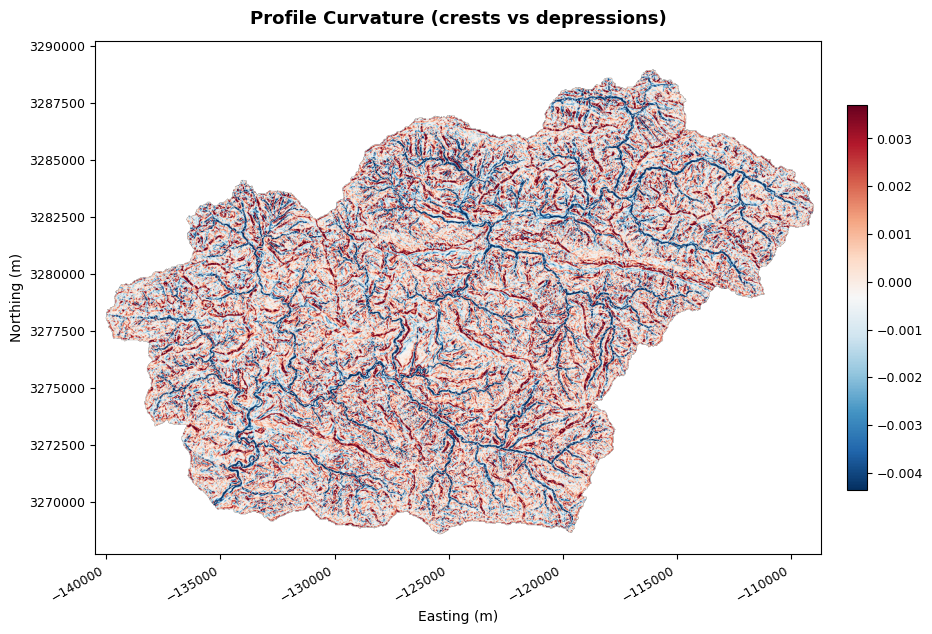

In [35]:
visualize_raster(
    prof_curv_file,
    title='Profile Curvature (crests vs depressions)',
    cmap='RdBu_r',
    percentile=(5, 95)
)

### Interpreting Curvature

**Blue (negative) values** indicate valleys and channels where flow converges (plan curvature) or concave slopes where flow accelerates (profile curvature).

**Red (positive) values** indicate ridges and noses where flow diverges (plan curvature) or convex slopes where flow decelerates (profile curvature).

**White (near zero)** indicates planar surfaces with minimal curvature.

## 3. Convergence Index

The Convergence Index measures whether terrain converges (forms valleys) or diverges (forms ridges). Negative values indicate convergent flow in valleys, channels, and hollows. Positive values indicate divergent flow on ridges, noses, and spurs. Zero indicates planar surfaces.

**SAGA Tool**: `ta_morphometry` module 1

For example, “Method” might have a drop-down menu like:

0 = Peucker & Douglas

1 = Tobler

And “Neighbours” will often have:

0 = 4 neighbors (rook)

1 = 8 neighbors (queen)

In [36]:
print("Calculating Convergence Index...\n")

convergence_file = os.path.join(config['output_dir'], 'saga_convergence.tif')

# Use the cleaned UTM-projected DEM
run_saga_tool(
    library='ta_morphometry',
    tool_id=1,
    parameters=[
        f'-ELEVATION={cleaned_dem}',
        f'-RESULT={convergence_file}',
        '-METHOD=0',
        '-NEIGHBOURS=0'
    ]
)

print(f"Convergence Index saved to: {convergence_file}")

Calculating Convergence Index...

Convergence Index saved to: results/saga_convergence.tif


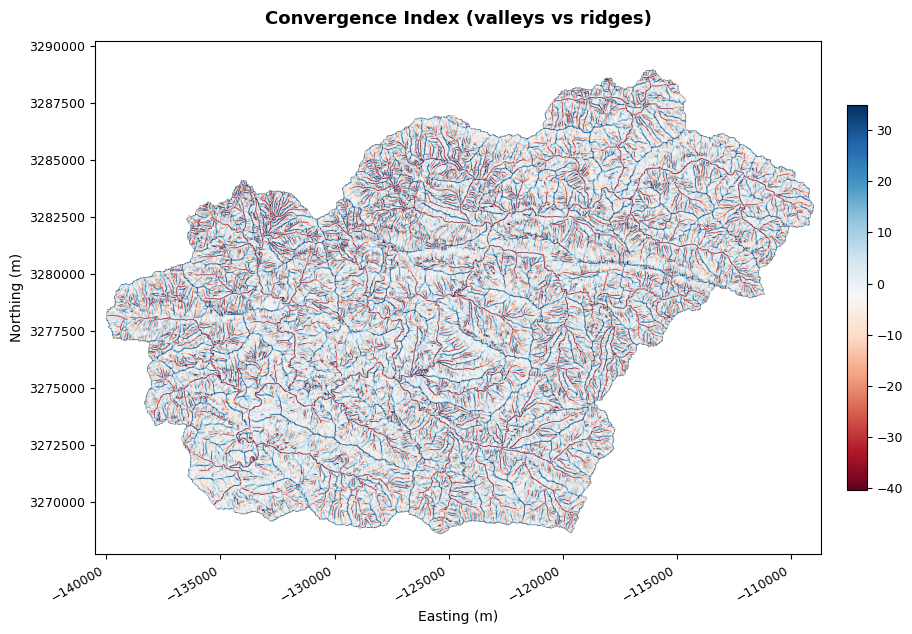

In [37]:
visualize_raster(
    convergence_file,
    title='Convergence Index (valleys vs ridges)',
    cmap='RdBu',
    percentile=(2, 98)
)

## 4. Topographic Wetness Index (TWI)

The Topographic Wetness Index predicts areas of moisture accumulation based on flow accumulation (contributing area) and local slope using the formula TWI = ln(a / tan(β)), where a is specific catchment area and β is slope angle.

High TWI values indicate potential wetlands and saturated soils. Low TWI values indicate well-drained conditions.

**SAGA Tool**: `ta_hydrology` module 15

In [38]:
print("Calculating Topographic Wetness Index...\n")

twi_file = os.path.join(config['output_dir'], 'saga_twi.tif')

run_saga_tool(
    library='ta_hydrology',
    tool_id=15,
    parameters=[
        f'-DEM={cleaned_dem}',
        f'-TWI={twi_file}'
    ]
)

print(f"TWI saved to: {twi_file}")

Calculating Topographic Wetness Index...

TWI saved to: results/saga_twi.tif


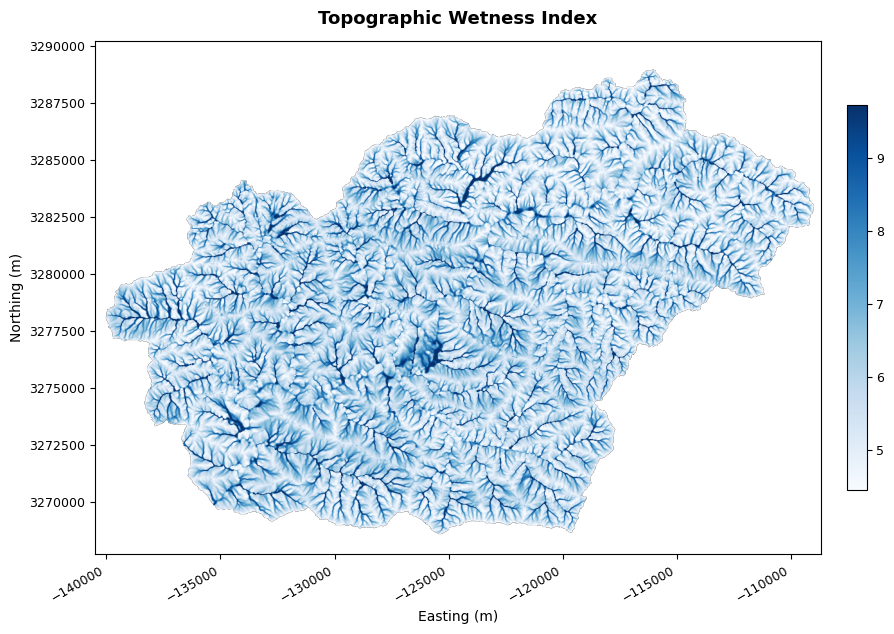

In [39]:
visualize_raster(
    twi_file,
    title='Topographic Wetness Index',
    cmap='Blues',
    percentile=(2, 98)
)

### Interpreting TWI

**High TWI values (dark blue)** indicate valley bottoms and channels with high moisture accumulation and potential wetlands.

**Low TWI values (light blue/white)** indicate steep slopes and ridge tops with well-drained, drier conditions.

## 5. Terrain Ruggedness Index (TRI)

The Terrain Ruggedness Index quantifies surface roughness by measuring the elevation difference between a cell and its neighbors. High values indicate rough, irregular terrain. Low values indicate smooth, flat terrain.

Applications include wildlife habitat assessment, erosion susceptibility, and trafficability analysis.

**SAGA Tool**: `ta_morphometry` module 16

In [40]:
print("Calculating Terrain Ruggedness Index...\n")

tri_file = os.path.join(config['output_dir'], 'saga_tri.tif')

# Use the cleaned UTM-projected DEM
run_saga_tool(
    library='ta_morphometry',
    tool_id=16,
    parameters=[
        f'-DEM={cleaned_dem}',
        f'-TRI={tri_file}',
        '-MODE=0'
    ]
)

print(f"TRI saved to: {tri_file}")

Calculating Terrain Ruggedness Index...

TRI saved to: results/saga_tri.tif


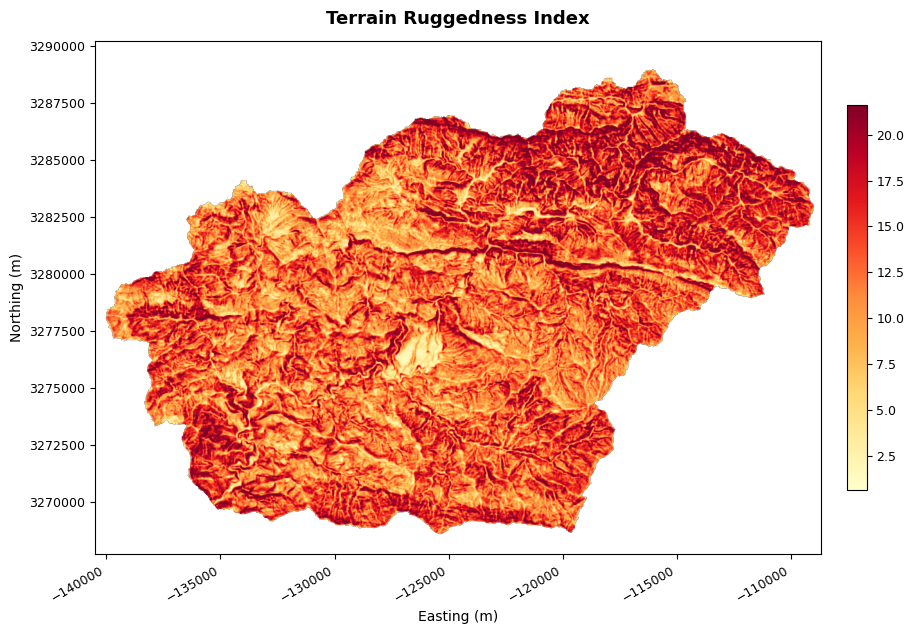

In [41]:
visualize_raster(
    tri_file,
    title='Terrain Ruggedness Index',
    cmap='YlOrRd',
    percentile=(0, 95)
)

## Comparative Visualization

This cell creates a comprehensive comparison of all SAGA terrain metrics side-by-side.

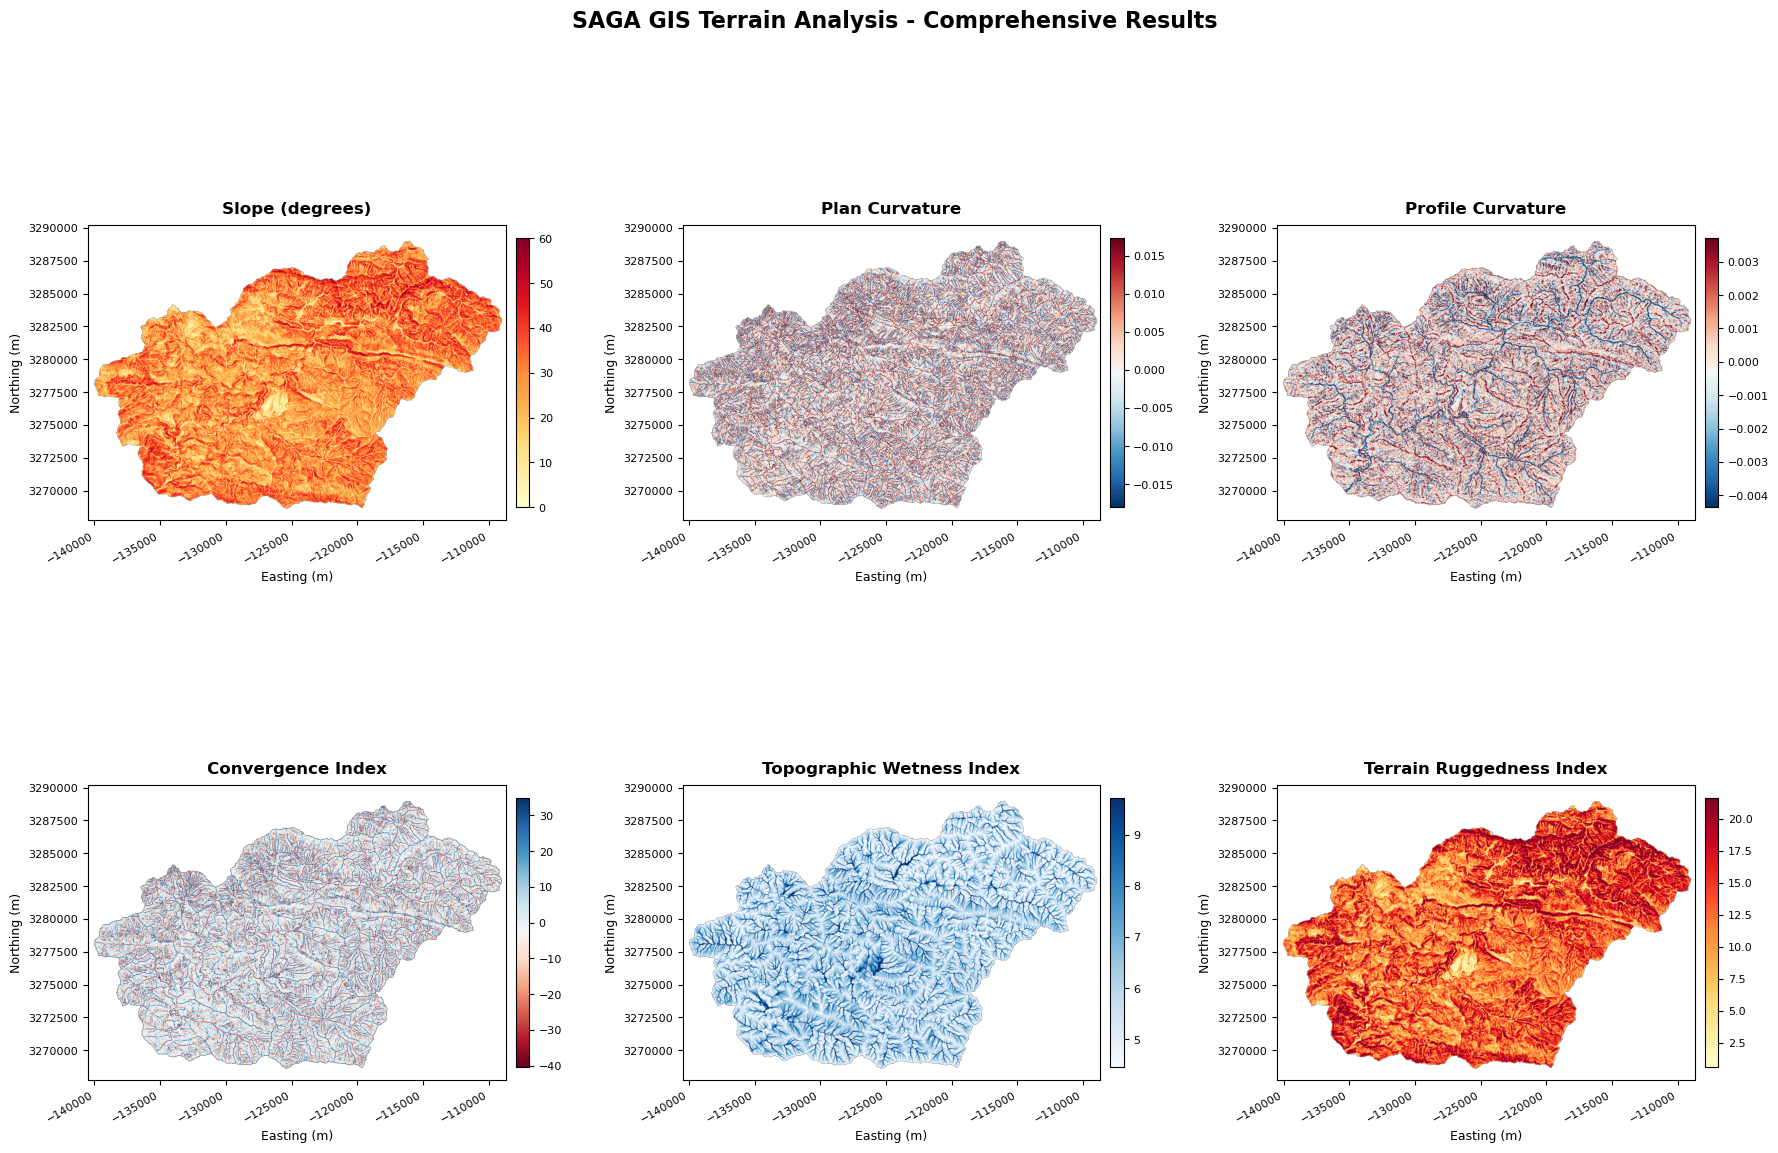


Comparison saved to: results/saga_terrain_comparison.png


In [43]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 3, figsize=(18, 13))
fig.suptitle('SAGA GIS Terrain Analysis - Comprehensive Results', 
             fontsize=16, fontweight='bold', y=0.98)

datasets = [
    (slope_file, 'Slope (degrees)', 'YlOrRd', None),
    (plan_curv_file, 'Plan Curvature', 'RdBu_r', (5, 95)),
    (prof_curv_file, 'Profile Curvature', 'RdBu_r', (5, 95)),
    (convergence_file, 'Convergence Index', 'RdBu', (2, 98)),
    (twi_file, 'Topographic Wetness Index', 'Blues', (2, 98)),
    (tri_file, 'Terrain Ruggedness Index', 'YlOrRd', (0, 95))
]

axes = axes.flatten()

for idx, (filepath, title, cmap, percentiles) in enumerate(datasets):
    if os.path.exists(filepath):
        with rasterio.open(filepath) as src:
            data = src.read(1, masked=True)
            extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
            crs = src.crs
        
        # Determine vmin/vmax
        if 'Slope' in title:
            vmin, vmax = 0, 60
        elif percentiles:
            valid_data = data[~data.mask] if hasattr(data, 'mask') else data[~np.isnan(data)]
            if len(valid_data) > 0:
                vmin, vmax = np.percentile(valid_data, percentiles)
            else:
                vmin, vmax = np.nanmin(data), np.nanmax(data)
        else:
            vmin, vmax = np.nanmin(data), np.nanmax(data)
        
        im = axes[idx].imshow(data, cmap=cmap, extent=extent, aspect='equal', vmin=vmin, vmax=vmax)
        axes[idx].set_title(title, fontsize=12, fontweight='bold', pad=8)
        
        # Set axis labels based on CRS
        if crs and crs.is_projected:
            axes[idx].set_xlabel('Easting (m)', fontsize=9)
            axes[idx].set_ylabel('Northing (m)', fontsize=9)
        else:
            axes[idx].set_xlabel('Longitude (degrees)', fontsize=9)
            axes[idx].set_ylabel('Latitude (degrees)', fontsize=9)
        
        axes[idx].ticklabel_format(style='plain', useOffset=False)
        plt.setp(axes[idx].get_xticklabels(), rotation=30, ha='right', fontsize=8)
        plt.setp(axes[idx].get_yticklabels(), fontsize=8)
        
        cbar = plt.colorbar(im, ax=axes[idx], shrink=0.4, pad=0.02)
        cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
comparison_file = os.path.join(config['output_dir'], 'saga_terrain_comparison.png')
plt.savefig(comparison_file, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"\nComparison saved to: {comparison_file}")

## Summary Statistics

In [44]:
import pandas as pd

stats_data = []

metrics = [
    (slope_file, 'Slope (degrees)'),
    (plan_curv_file, 'Plan Curvature'),
    (prof_curv_file, 'Profile Curvature'),
    (convergence_file, 'Convergence Index'),
    (twi_file, 'Topographic Wetness Index'),
    (tri_file, 'Terrain Ruggedness Index')
]

for filepath, metric_name in metrics:
    if os.path.exists(filepath):
        stats = compute_statistics(filepath)
        stats_data.append({
            'Metric': metric_name,
            'Min': f"{stats['min']:.2f}",
            'Max': f"{stats['max']:.2f}",
            'Mean': f"{stats['mean']:.2f}",
            'Median': f"{stats['median']:.2f}"
        })

stats_df = pd.DataFrame(stats_data)
print("\nSAGA Terrain Metrics Summary:")
print(stats_df.to_string(index=False))


SAGA Terrain Metrics Summary:
                   Metric    Min   Max  Mean Median
          Slope (degrees)   0.02 70.24 28.59  29.06
           Plan Curvature  -3.34  9.17  0.00   0.00
        Profile Curvature  -0.03  0.02 -0.00  -0.00
        Convergence Index -91.43 94.84 -0.00   0.38
Topographic Wetness Index   3.20 13.08  6.06   5.72
 Terrain Ruggedness Index   0.63 58.65 13.47  13.17


## Summary

This tutorial demonstrated SAGA GIS terrain analysis capabilities. Slope measures terrain steepness while Aspect shows slope direction. Plan Curvature reveals horizontal bending patterns indicating flow convergence or divergence. Profile Curvature shows vertical bending affecting flow acceleration. Convergence Index characterizes valleys versus ridges. TWI predicts moisture accumulation patterns. TRI quantifies surface roughness.

All analyses used the UTM-projected watershed DEM to ensure accurate calculations in metric units. These terrain derivatives are fundamental for understanding landscape character and are used in hydrology, ecology, geomorphology, and land use planning applications.